# Лабораторная работа №3
## Левицкий Валентин А-13-22
## Вариант №22

# Задача 3.1 
Реализовать решение СЛАУ с помощью LU разложения и LU разложения по схеме частичного выбора. Решить систему небольшой размерности с возмущенной матрицей обоими методами, оценить погрешность и сравнить с теоретической оценкой. Проанализировать поведение  методов с ростом числа уравнений.

$A_{ij} = \arctan(0.1 (10i + j + 1)).$

## Решение

Зададим матрицу

In [310]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=180)

N = 22
m = 5
def init_matr(m):
    matr = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            matr[i][j] = np.arctan(0.1 * (10 * i + j + 1))
            # matr[i][j] = (i * m + j + 1)
    return matr
A = init_matr(m)
x_root = np.ones((m, 1)) * N
b = A.dot(x_root)
A

array([[0.09966865, 0.19739556, 0.29145679, 0.38050638, 0.46364761],
       [0.83298127, 0.87605805, 0.9151007 , 0.95054684, 0.98279372],
       [1.12637712, 1.14416883, 1.16066899, 1.17600521, 1.19028995],
       [1.25875421, 1.26791146, 1.27656176, 1.28474489, 1.29249667],
       [1.33156473, 1.33705315, 1.34229969, 1.34731973, 1.35212738]])

1. Реализуем метод решения СЛАУ с помощью LU разложения по схеме единственного деления, модифицирующий исходную матрицу A:

In [311]:
def LU(A) -> np.array:
    lu = A.copy()
    for i in range(1, A.shape[0]):
        for j in range(0, i):
            mu = lu[i, j] / lu [j, j]
            mask = np.ones_like(lu[j, :])
            mask[:j] = 0
            # print(lu[j, :] * mask)
            lu[i, :] -= mu * (lu[j, :] * mask)
            lu[i, j] = mu
    return lu

def solve(A, b):
    lu = LU(A)
    l = np.tril(lu, -1) + np.eye(lu.shape[0])
    u = np.triu(lu)
    # print(l)
    # print(u)
    y = np.linalg.inv(l).dot(b)
    x = np.linalg.inv(u).dot(y)
    # return l, u
    return x


Убедимся в работоспособности метода:

In [312]:
solve(A, b).T

array([[22.        , 22.        , 22.00000001, 22.        , 22.        ]])

2. Реализуем метод решения СЛАУ с помощью LU разложения по схеме частичного выбора в виде двух функций, одна из которых возвращает две матрицы – L и U, не модифицируя A, а вторая функция решает систему.

In [302]:
def Mimod(A, k, is_l):
    mi = np.eye(*A.shape)
    P = np.eye(*A.shape)
    mx = k + np.argmax(np.abs(A[k:, k]))
    P[[k, mx]] = P[[mx, k]]
    A = P.dot(A)
    for i in range(k + 1, A.shape[1]):
        mi[i, k] = A[i, k] / A[k, k]
        if not is_l:
            mi[i, k] *= -1
    return mi, P

def LUmod(A):
    U = A.copy()
    L = np.eye(*A.shape)
    M = np.eye(*A.shape)
    for j in range(0, A.shape[1] - 1):
        mi, pi = Mimod(U, j, False)
        mii, pii = Mimod(U, j, True)
        # M = pii.dot(mii).dot(M).dot(mi).dot(pi)
        # print(pi)
        U = mi.dot(pi).dot(U)
        L = L.dot(pii).dot(mii)
        # print(l)
    return L, U

def solvemod(A, b):
    L, U = LUmod(A)
    y = np.linalg.inv(L) @ b
    x = np.linalg.inv(U) @ y
    return x

In [313]:
solvemod(A, b).T

array([[22.        , 21.99999999, 22.00000002, 21.99999998, 22.        ]])

Убедимся в работоспособности метода:

In [304]:
x = solvemod(A, b)

3. Решим систему  $A^*x = b$, размера 5 x 5, двумя методами. $A^*$ зададим как $A$ и к одному элементу прибавим $10^{-3}$  

In [305]:
A_star  = A.copy()
A_star[3, 3] += 0.001
x1 = solve(A_star, b)
x2 = solvemod(A_star, b)

4. Вычислим погрешности и сравним с теоретической оценкой.

In [306]:
Dx1 = np.linalg.norm(x_root - x1)
Dx2 = np.linalg.norm(x_root - x2)
DA = np.linalg.norm(A - A_star)
dx1 = Dx1 / np.linalg.norm(x_root)
dx2 = Dx2 / np.linalg.norm(x_root)
dA = DA / np.linalg.norm(A)
condA = np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A))
d_hat = condA * DA
print(f'{dx1 = }')
print(f'{dx2 = }')
print(f'Теоретическая оценка: {d_hat}')

dx1 = 0.8568133536857635
dx2 = 0.8568133536692295
Теоретическая оценка: 56493.659253590085


Погрешность решений полученых обоими методами находится в пределах теоретической оценки.

5. Решим систему обоими методами для матриц большей размерности. Построить на одном графике погрешности обоих методов как функций, зависящих от $n$.
   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


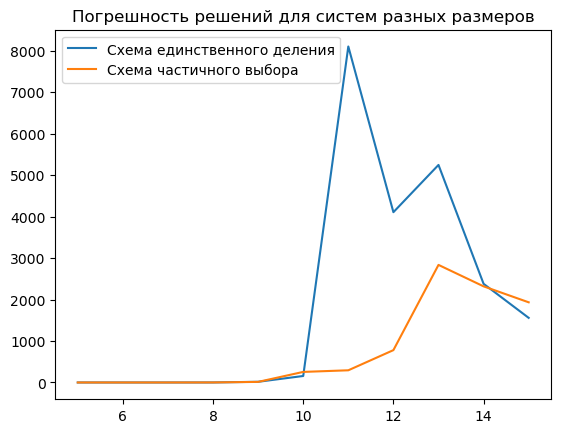

In [307]:
dts1 = []
dts2 = []
for n in range(5, 16):
    M = init_matr(n)
    x_root = np.ones((n, 1)) * N
    b = M.dot(x_root)
    x1 = solve(M, b)
    x2 = solvemod(M, b)
    dts1.append(np.linalg.norm(x_root - x1))
    dts2.append(np.linalg.norm(x_root - x2))
X = np.arange(5, 16)
plt.plot(X, dts1, label='Схема единственного деления')
plt.plot(X, dts2, label='Схема частичного выбора')
plt.legend()
plt.title('Погрешность решений для систем разных размеров')
plt.savefig('report/311.eps')

Из графиков видно, что погрешность прямых методов возрастает с размерами системы, при этом метод частичного выбора дает более точный результат.

# Задача 3.2

Дана разреженная матрица A. Найти число обусловленности матрицы.

## Решение

In [29]:
import numpy as np

In [317]:
N = 22
m = 20
eps = 10**(-10)

1. Зададим матрицу А согласно схеме из приложения: все ненулевые элементы матрицы равны $N$ ( номеру варианта), элементы главной диагонали равны  $N*m+m/N$,  $m$ - размерность матрицы.

In [318]:
A = np.eye(20, 20)
A[:8,:4] = N
A[8:14, 4:8] = N
A[14:, :8] = N
for i in range(8, m-1):
    A[i, i+1:] = N
for i in range(m):
    A[i, i] = (N*m + m/N)

2.Разработаем  и реализуем алгоритм решения системы с данной матрицей А  прямым методом с учетом нулевых элементов.

In [332]:
def zerofy(B, n):
    """Зануляет элеметны строки n, находящиеся под главной диагональю."""
    for i in range(0, n):
        mu = B[n, i] / B[i, i]
        B[n, :] -= mu * B[i, :]
    return B

def simplify(A, b):
    """Приводит разреженную матрицу А к двухдиагональному виду"""
    B = np.concatenate((A, b), axis = 1)
    for i in range(1, 8):
        B[i-1, :] -= B[i, :]
    for i in range(9, 20):
        B[i-1, :] -= B[i, :]
    B = zerofy(B, 7)
    B = zerofy(B, 13)
    B = zerofy(B, 19)
    return B[:, :-1], B[:, -1]

def backward(A, b):
    """Обратный ход для двухдиагональной матрицы"""
    x = np.zeros_like(b)
    x[-1] = b[-1] / A[-1, -1]
    for i in range(b.size-2, -1, -1):
        x[i] = (b[i] - A[i, i+1] * x[i+1]) / A[i, i]
    return x

def fast_solve(A, b):
    return backward(*simplify(A, b))

Выполним проверку взяв вектор $x$, состоящий из одинаковых элементов $33$:

In [333]:
x_root = np.ones((20, 1)) * 33
x_root
b = A.dot(x_root)
fast_solve(A, b)

array([33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33., 33.])

In [334]:
np.round(simplify(A, b)[0])

array([[ 419., -419.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,  419., -419.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,  419., -419.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,  419., -441.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,  441., -441.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,  441., -441.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,  441., -441.,    0.,    0.,    0.,    0.,    0.,    0., 

3. Напишим алгоритм для поиска обратной матрицы, основанный на решении уравнений $Ax^j=E^j$, где $E^j$ - столбцы единичной матрицы, проверим работоспособность:

In [34]:
def inv(A):
    ans = np.eye(*A.shape)
    for j in range(A.shape[1]):
        ans[:, j] = fast_solve(A, ans[:, j].reshape(A.shape[0], 1))
    return ans

Проверим работоспособность алгоритма:

In [35]:
np.max(np.abs(inv(A).dot(A) - np.eye(20, 20)))

2.220446049250313e-16

4. Найдем число обусловленности матрицы, используя евклидову норму:

In [36]:
condA = np.linalg.norm(A) * np.linalg.norm(inv(A))
print(condA)

20.37275136439184


## Вывод
1. Данная матрица является хорошо обусловленной т.к. $cond A < 100$;
2. Трудоемкость метода составила:
   - 57m вычитаний, 3m умножений - функция simplify;
   - 3m вычитаний и умножений - функция backward
   - Итого ~63m операций, т.е. сложность алгоритма - линейная.

# Задача 3.3
Дана система уравнений $Ax = b$. Решить  систему методом Якоби с точностью $\varepsilon = 10^{-10}$.   

In [37]:
import numpy as np
import matplotlib.pyplot as plt
N = 22
m = 20
eps = 10**(-10)

1. Составим программу преобразования системы $Ax = b$ к виду $x = Bx + c$.

In [38]:
A = np.eye(20, 20) * 1 #(N*m + m/N)
A[:8,:4] = N
A[8:14, 4:8] = N
A[14:, :8] = N
for i in range(8, m-1):
    A[i, i+1:] = N
for i in range(m):
    A[i, i] = (N*m + m/N)

b = np.zeros((20, 1))
b[:,0] = np.abs(N - 25) + 5

In [39]:
def Jacobi(A, b):
    '''
    Перобразует СЛАУ Ax=b
    к виду x = Bx + c.
    '''
    B = np.zeros_like(A)
    c = np.zeros_like(b)
    for i in range(A.shape[1]):
        B[i, :] = -A[i, :] / A[i, i]
        B[i, i] = 0
        c[i,0] = b[i,0] / A[i, i]
    return B, c

def inf_norm(A):
    return np.max(np.sum(np.abs(A), axis=1))

def euclid_norm(A):
    return np.sqrt(np.sum(A**2))
    

Убедимся, что выполнено достаточное условие сходимости метода: $||B|| < 1$

In [40]:
B, c = Jacobi(A, b)
np.linalg.norm(B)

0.6428766787355629

Составим программу метода простых итераций с подсчетом нормы вектора невязки на каждой итерации.

In [44]:
def MPI(A, b, eps):
    B, c = Jacobi(A, b)
    x0 = c
    x1 = B.dot(x0) + c
    iters = 1
    r_n = []
    k = (1 - inf_norm(B)) / inf_norm(B)
    while inf_norm(x1 - x0) > k * eps:
        r_n.append(euclid_norm(A.dot(x1) - b))
        x0 = x1
        x1 = B.dot(x1) + c
        iters +=1
    print("Выполнено итераций: ", iters)
    return x1, np.array(r_n)

2. Найдем решение задачи с заданной точностью.

In [45]:
x, r_n = MPI(A, b, eps)

Выполнено итераций:  13


Подставим найденое решение в исходное уравнение и убедимся в корректности метода:

In [48]:
A.dot(x).T

array([[8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
        8., 8., 8., 8.]])

Нормы векторов невязки по итерациям:

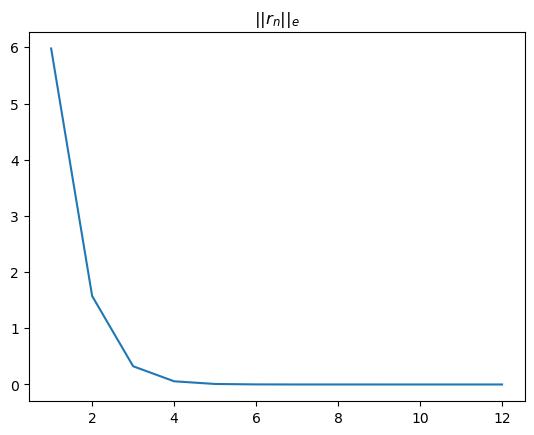

In [47]:
plt.plot(np.arange(1, r_n.size + 1), r_n)
plt.title('$||r_n||_e$')
plt.savefig("report/fig331.eps")